## Vulnerability analisys using Python

This exercise aims analizing the vulnerability (susceptibility) to pollution for groundwater reservoirs located inside the **La Rioja** Automonous Comunity (Spain). For this purpose, the **DRASTIC** model will be used. The parameters and weights which the model considers are as follows:

- (**D**) Groundwater depth -> 5
- (**R**) Net recharge -> 4
- (**A**) Nature of the aquifer -> 3
- (**S**) Type of soil -> 2
- (**T**) Topography / Slope -> 1
- (**I**) Impact of non-saturated areas -> 5
- (**C**) Permeability -> 3

The vulnerability (V) is evaluated using the following formula:

*V = DvDp * RvRp * SvSp * TvTp * IvIp * CvCp* 

Where *v* and *p* are the values and weights, respectively.


Possible values for DRASTIC could range between 23 to 226 points, however, it ranges more tipically between 50 and 200 points. Since the vulnerability intervals are usually defined based on the specific application; for this case, the following classes were established:

* Insignificant ->  **< 100**
* Very low -> **100 - 119**
* Low -> **120 - 139**
* Moderate -> **140 -159**
* High -> **160 - 179**
* Very high -> **180 - 199**
* Extrem -> **>= 200**


#### Available Datasets
The following list describes the datasets usedf for the current analysis

- *La_Rioja.shp*: Administrative boundaries of La Rioja
- *Geologia_CHEbro.shp*: Geology of the Ebro watershed
- *Niveles_Agua.shp*: Groundwater leves in La Rioja
- *Dom_HG_CHEbro.shp*: Hydrogeological domains in the Ebro watershed
- *Unid_HG_CHEbro.shp*: Hydrogeological units in the Ebro watershed
- *Impacto_Zona_Saturada.dbf*: Table containing the impact values for non-saturated areas
- *Nat_Acuifero.dbf*: Table containing the nature of the aquifer values
- *Pendientes.dbf*: Slope values
- *Nivel_Agua.xls*: Water depth levels
- *Permeabilidad.dbf*: Permeability values
- *Recarga.dbf*: Net recharge values
- *Suelo.xls*: Soil type values
- *Topografia.xls*: Topography values

### Importing Packages and Datasets

In [54]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [12]:
# Load first any layer that has a CRS already assigned
water_levels = gpd.read_file('data/Niveles_Agua.shp')
water_levels.crs

<Derived Projected CRS: EPSG:23030>
Name: ED50 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - between 6°W and 0°W - Channel Islands (Jersey, Guernsey); France offshore; Gibraltar; Ireland offshore; Norway including Svalbard - offshore; Spain - onshore; United Kingdom - UKCS offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Datum 1950
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [21]:
rioja_aoi = gpd.read_file('data/La_Rioja.shp')
rioja_aoi.crs = water_levels.crs

In [22]:
rioja_aoi.geometry

0    POLYGON ((491736.500 4675703.500, 491824.531 4...
Name: geometry, dtype: geometry

,minx,miny,maxx,maxy
0,489129.96875,4641442.5,609165.625,4721609.5


In [41]:
# load the rest of the layers and apply a mask so that only the elements inside the AOI are loaded
slopes = gpd.read_file('data/Pendientes.shp', mask=rioja_aoi)
geology = gpd.read_file('data/Geologia_CHEbro.shp', mask=rioja_aoi)
hydro_domains = gpd.read_file('data/Dom_HG_CHEbro.shp', mask=rioja_aoi)
hydro_units = gpd.read_file('data/Unid_HG_CHEbro.shp',  mask=rioja_aoi)
water_levels = gpd.sjoin(left_df=water_levels, right_df=rioja_aoi, lsuffix='')[['NOMBRE_', 'NIVEL_AGUA', 'geometry']]

In [52]:
slopes = gpd.read_file('data/Pendientes.shp', mask=rioja_aoi)


In [43]:
water_levels.rename(columns = {'NOMBRE_': 'NOMBRE'}, inplace=True)
water_levels.head()

,NOMBRE,NIVEL_AGUA,geometry
0,CENICERO,47.0,"POLYGON ((527359.628 4706653.730, 527446.125 4..."
1,CERVERA DEL RÍO ALHAMA,23.0,"POLYGON ((589055.000 4661021.000, 589330.000 4..."
2,CIDAMÓN,35.0,"MULTIPOLYGON (((515635.000 4702536.000, 515053..."
3,CORNAGO,46.0,"POLYGON ((578214.000 4662724.000, 578290.000 4..."
4,ENCISO,60.0,"POLYGON ((560891.000 4669511.000, 561045.000 4..."


In [53]:
water_levels.head()

,NOMBRE,NIVEL_AGUA,geometry
0,CENICERO,47.0,"POLYGON ((527359.628 4706653.730, 527446.125 4..."
1,CERVERA DEL RÍO ALHAMA,23.0,"POLYGON ((589055.000 4661021.000, 589330.000 4..."
2,CIDAMÓN,35.0,"MULTIPOLYGON (((515635.000 4702536.000, 515053..."
3,CORNAGO,46.0,"POLYGON ((578214.000 4662724.000, 578290.000 4..."
4,ENCISO,60.0,"POLYGON ((560891.000 4669511.000, 561045.000 4..."


In [55]:
slopes.head()

,PEND,geometry
0,5.0,"POLYGON ((501225.000 4720678.000, 501211.719 4..."
1,2.0,"POLYGON ((506411.000 4718991.000, 506336.406 4..."
2,9.0,"POLYGON ((512573.906 4718424.500, 512529.250 4..."
3,2.0,"POLYGON ((499545.781 4719956.500, 499558.219 4..."
4,3.0,"POLYGON ((518794.703 4716745.982, 518767.812 4..."


In [66]:
def plot_geodataframes(gdf: gpd.GeoDataFrame, title: str = '', **plot_args) -> None:
    plot_fig, plot_ax = plt.subplots(figsize=(10, 6))
    plot_ax.set_title(title)
    gdf.plot(ax=plot_ax, **plot_args)
    rioja_aoi.plot(ax=plot_ax, facecolor='none',  edgecolor='#023858', linewidth=3)

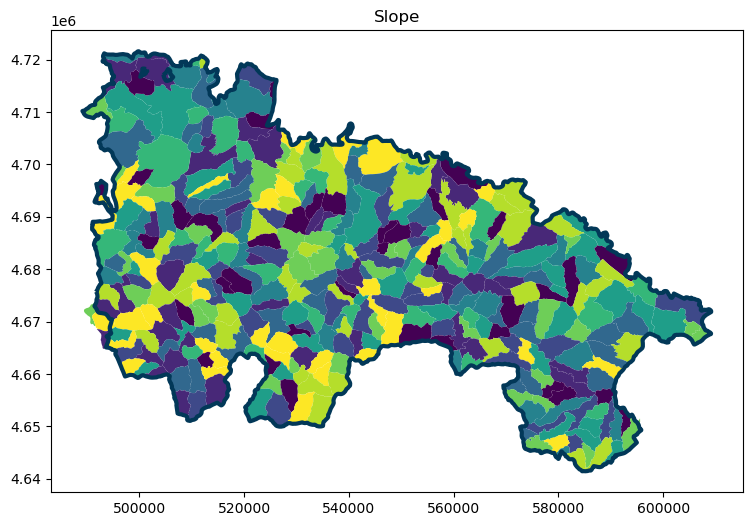

In [67]:
plot_geodataframes(slopes, title='Slope', cmap='viridis', column='PEND', edgecolor=None)

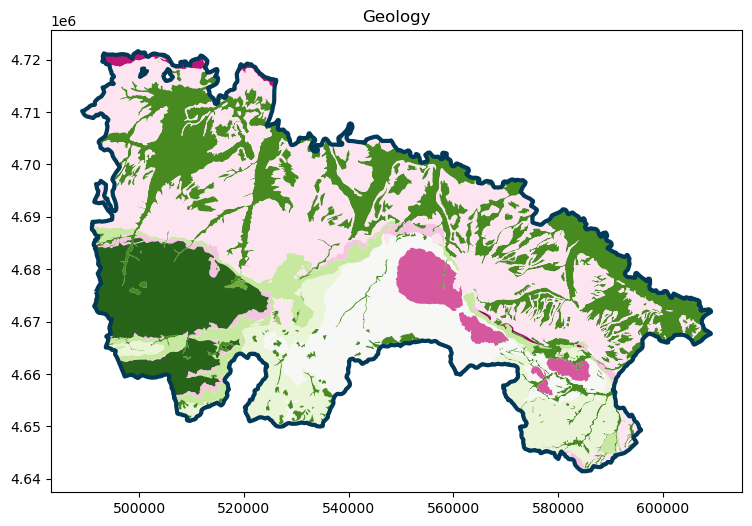

In [73]:
plot_geodataframes(geology, title='Geology', cmap='PiYG', column='MATERIALES', edgecolor=None)

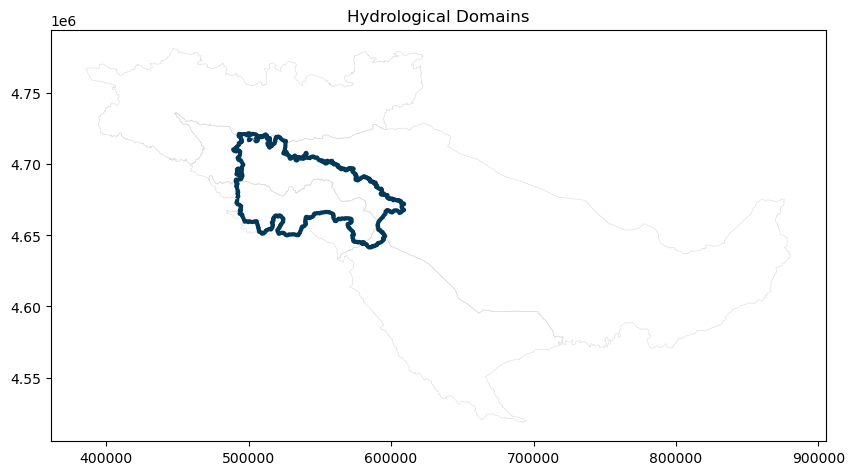

In [75]:
plot_geodataframes(hydro_domains, title='Hydrological Domains', facecolor='none', edgecolor='#d9d9d9', linewidth=0.4)

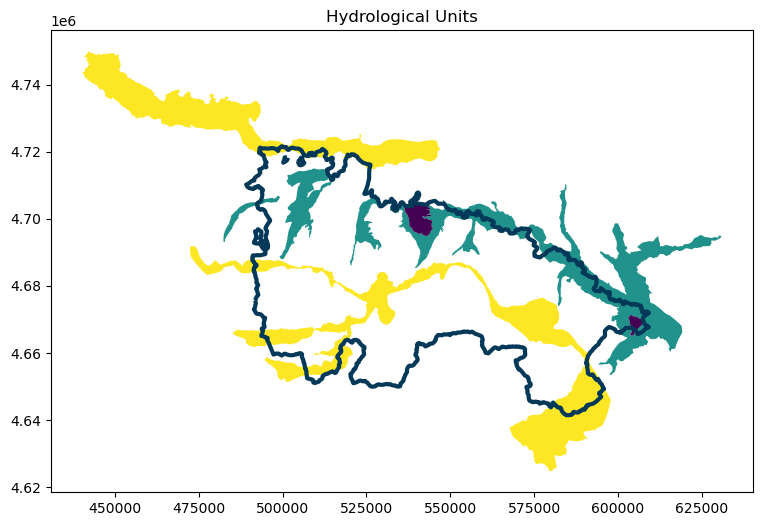

In [78]:
plot_geodataframes(hydro_units, title='Hydrological Units', cmap='viridis', column='TIPO', edgecolor=None)

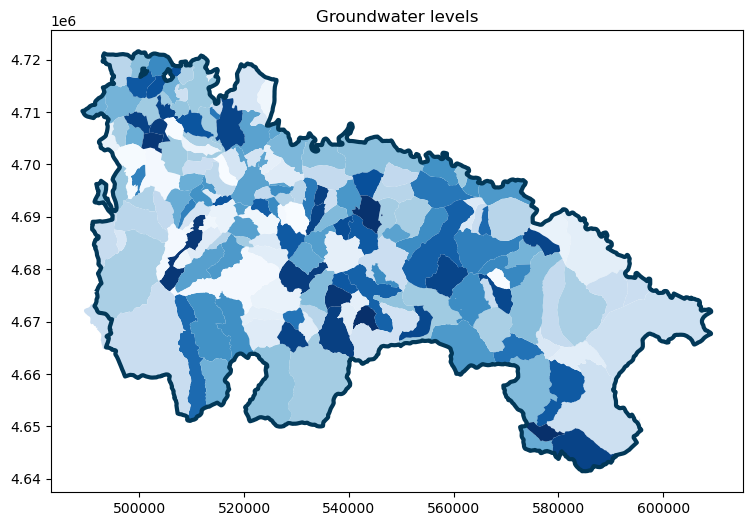

In [80]:
plot_geodataframes(water_levels, title='Groundwater levels', cmap='Blues', column='NIVEL_AGUA', edgecolor=None)